<div style="border:1px solid black; padding:20px 20px;text-align: justify;text-justify: inter-word">
   
# MICRO-452: Project Report - Groupe 20

**Authors:** Nathan Guillaumat, Hana Catic, Alexei Ermochkine, Joey Kodeih

**Teacher:** Prof. Francesco Mondada

**Due date:** 07.12.2023

## Table of Contents
<ol type="I">
<li>Introduction</li>
<li>Defining the environment</li>
<li>Vision</li>
<li>Global Navigation</li>
<li>Motion Control</li>
<li>Extended Kalman Filter</li>
<li>Local Navigation</li>
<li>Main</li>
<li>Conclusion</li>
<li>Final code</li>
</ol>

## I Introduction

In the scope of our course, "Basics of Mobile Robotics," we undertook a comprehensive project that integrated the key concepts covered throughout the semester's exercise sessions. Our objective was to synthesize our understanding of Global Navigation, Local Navigation, Filtering, Motion Control, and Vision into a practical application. The project encompassed several essential goals:
- Environment Creation: We created a setting with a predetermined set of obstacles. The Thymio robot has to find its way around this environment on its own, avoiding obstacles without using sensors to detect them.
- Pathfinding: The main goal was to direct the Thymio robot to a destination located anywhere in the surroundings from an arbitrary starting place. We were able to evaluate the system’s adaptability because of its capacity to change the target’s location
- Motion control and pose estimation: Precise control was applied to enable the robot to travel along the predetermined path. Kalman filtering was used to estimate the pose accurately, which was necessary to do this.
- Obstacle Avoidance: The Thymio was able to avoid obstacles that were purposefully positioned in its route at any given time by using the front proximity sensors. 

This project helped us gain a greater understanding of the principles of mobile robotics by not only providing a comprehensive application of theoretical concepts but also challenging us to integrate and apply these principles in a real-world robotic scenario.

You will find attached recordings of demonstrations of our code in the `videos_report` folder.

For an easier read of this report and the examples, let's import the funct for each code cell.

In [1]:
import os
import sys
import math
from statistics import mean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


import cv2
import time

#### Constants

In [2]:
# Variances
qpx = 0.25 # variance on position state
qpy = 0.25 
rpx = 0.01 # variance on position measurement 
rpy = 0.01

std_speed = 11.77
q_theta_nu = std_speed/2 # variance on speed state
r_theta_nu = 0.1# std_speed/2 # variance on speed measurement 

# units: length [mm], time [s]
A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
Q = np.array([[qpx, 0, 0], [0, qpy, 0],[0, 0, q_theta_nu]]); #w matrix
rotation_conv_factor = 0.41; #0.8 for 50 speed, 0.41 for 100 speed
speed_conv_factor_straight = 0.338; #straight
speed_conv_factor_left = 0.403;
speed_conv_factor_right = 0.425;

transition_thresh = 500
l = 100 #mm, distance between the two wheels


#### Importation of the .py files

In [3]:
from globalNavigation import *
from helpers import *
from vision import *

## II Defining the environment

<center><img src="attachment:5c614210-e843-42c2-aef6-aceb6108e551.jpg" width="500"/><center>
<center> Map of the project </center>


For this project, we chose to define the map as being an open map, where the thymio can move freely in any directions on the map. The static obstacles are defined by the black rectangle shapes, that will always be alligned with the cameraframe edges  for the ease of the vision, and the global navigation calculation. The goal is defined by the green dot, and the thymio by the two red dots : the small one is the front of the thymio, the big one the center of the thymio. The thymio will be connected wirelessto avoid any slip due to the cable. 

# III Vision

Having freedom to define the environment (almost) as we please made the vision module simpler. Indeed, knowing what to look for, and what exactly can and cannot be in the frame makes the job more straightforward. As the environment was defined above, we need only a few functions to recognize:
- the thymio's location and orientation with `locate_thymio`
- the static obstacle's corners with `locate_static_obstacles`
- and the goal's location with `locate_goal`

Note that we do not need to account for "cropping" because we position the camera such that the environment is whatever is in the frame. 

All 3 functions apply masks on the image in HSV-space (for red, black and green each), a better method than in RGB. A Gaussian blur is used to help with texture and reflections. Some specifics:
- `locate_goal` looks for a green shape and computes its center.
- `locate_thymio` looks for red shapes and keeps the 2 biggest area-wise, computes their centers and obtains the angle knowing that the smaller shape of the two is the "front" of thymio
- `locate_static_obstacles` finds black shapes and using K-means, groups the shapes by their area size in k=2 groups and only keeps the group with the highest mean area (this eliminates the possible detected shadows and artifacts). Then the corners are found as the bounding rectangle around the shape (thus why the obstacles need to be aligned with frame). Note that the bounding rectangle is bigger than the actual obstacle: it's to account for thymio's size, since the global navigation essentially creates a path between corners, we want thymio to stay away from the actual obstacle. The bounding rectangles are enlarged by a custom, constant amount.

Additionally, a notebook called `camera_feed.ipynb` runs separately from the main code and displays the camera's feed with the path constructed by global navigation. Simply run the cells in the code once the desired environment is set (obstacles, thymio and goal) and then run the main code (this notebook). You can now observe the thymio following the created path.

A custom conversion of pixels to millimeters is made (0.4 mm/px) by knowing the real size of static obstacles and its size in pixels. Note that this has to be recalculated manually if the setup changes (camera height can change for example).


### Example of the start
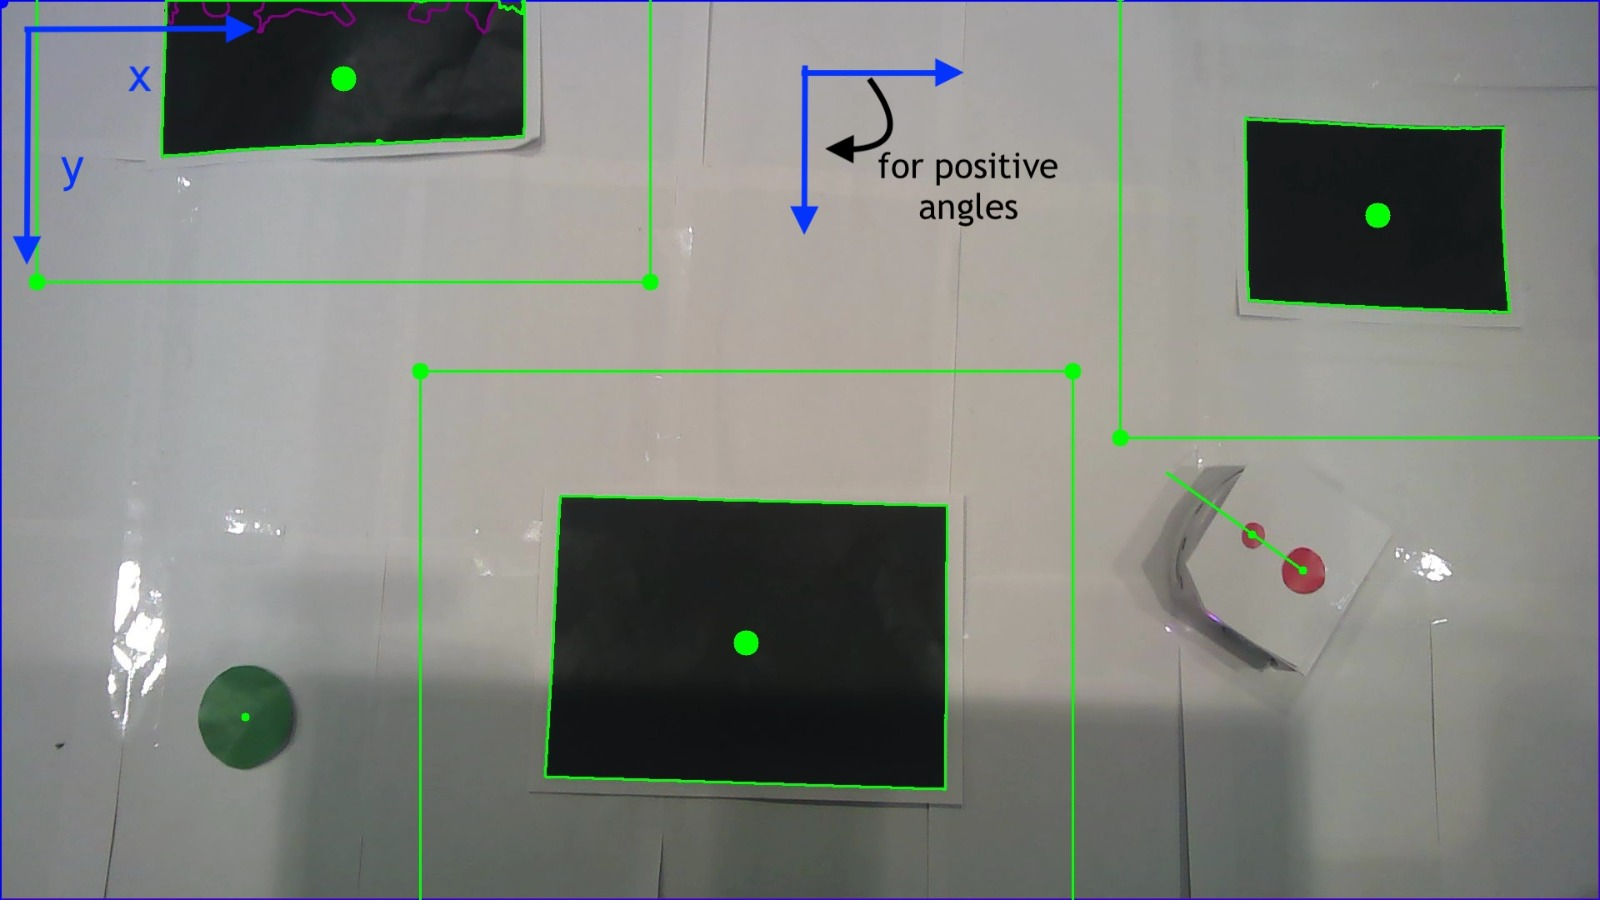
<center>Visualisation of the map, the obstacles, the Thymio and its orientation</center>

### Example of use of `camera_feed.ipynb` 
<center><img src="attachment:7226fc74-897c-41e6-8858-159bc74abbf6.jpg" width="500"/><center>
<center>Path chosen and nodes in red </center>

## IV Global navigation
Path planning problem is the problem of planning an optimal path from a given start position to a given goal position. To solve this problem there are several requirements:

- a global map,
- start and end position,
- path planning algorithm and
- controller.

It is assumed that at the robot is in an unfamiliar environment, where there are two types of obstacles, static obstacles and dynamic obstacles. Global navigation deals with static obstacles. In order to be able to devise a plan in such an environment the robot first needs to capture the conectivity of the free space into a graph that can later be search for paths. For this purpose visibility graph is used. And the graph generated by this algorithm is later used in the A* algorithm to find the optimal path in that graph.

### Visibility graph

Visibility graph uses information about the obstacles provided by vision, namely the vertices of the obstacles, enlarged, so as to ensure that the robot will not graze the obstacles. Information is given in of a list of obstacles which are represented as a list of points. This algorithm constructs a set of roads that will enable the robot to move from the start to the goal, while minimizing the total road. It joins all pairs of vertices that can see eachother including initial and goal position. It is a complete algorithm.

Because of the way that the environment is defined, with only a few obstacles, and hence not many vertices, even the naive implementation of this algorithm which has time complexity $O(n^3)$ will have good results, and isn’t much slower than other faster implementations such as Lee's implementation. (Lee, Der-Tsai. Proximity and reachability in the plane. University of Illinois at Urbana-Champaign, 1978.) This algorithm is implemented in a python open source library pyvisgraph. Detailed description and code is available on github (https://github.com/TaipanRex/pyvisgraph).

This library implements Lee’s algorithm, rather than the naive version, so only the classes *Point*, *Edge* and *Graph* were used, along with some basic functions *orientation*, *on_segment*, *edge_in_polygon*, but the latter was modified for the scope of the project.  While functions *build_graph*, *point_in_polygon* and *visible_vertices* were inspired by the functions with the same name in the library. Additionally, function *point_in_polygon* was inspired by following article https://www.geeksforgeeks.org/how-to-check-if-a-given-point-lies-inside-a-polygon/.

### Naive implementation

Note that the naive implementation iterates over all of the points in the graph and checks visibility with all of the other points in the graph, and checks interstions with all of the edges of the obstacles, if they don't intersect then the pair of points defines a visibile edge. Let the n be the number of points, each point can be paired up with other (n-1) points, and checks intersection with n edges, let p be the number of polygons, if they have n vertices, they have in total n edges. This gives the overall time complexity of $O(n^3)$.

### Basic functions 

Function *orientation* determines the orientation of three ordered points, based on the difference of slope - angle of the two segments defined respectively with the first and second point, and second and third point. Explanation along with the photo is taken from (https://www.geeksforgeeks.org/orientation-3-ordered-points/)
<center><img src="attachment:e270df1a-bd1a-4309-89b2-43d3915d9609.jpg" width="300"/></center>
<center>Nodes connection</center>

Function *on_segment* checks if a point collinear with an edge is on the edge by simply checking if the point is inside a square aligned with the x and y axis, defined by the edge as the diagonal.

Function *edge_in_polygon* checks if an edge is inside a polygon, this is only possible if both vertices of the edge are part of the same polygon. In this case, the middle point of the segment is inside the polygon, here we don't assume that the obstacles, polygons, are convex, to perfom this check function *point_in_polygon* is used. This function checks if the number of intersections of a half-line from p1 to (-$\infty$, p1.y) and the polygon, if it's an odd number of intersections the point is inside the polygon.

Function *visible_vertices* finds vertices seen from one of the points in the free space. It loops over all of the vertices in the graph, including the start and goal if provided, and checks if there is an intersection between the edge defined by this pair of point and any of the edges of the obstacles. Since the obstacles don't have to be convex, and in case of any obstacle except triangles there are diagonals which might be inside the polygon, this case also needs to be checked by calling the function *edge_in_polygon*.

Function *build_graph* builds the graph based on the global map, the occupied space on the map. This is where the visibility graph is implemented, it calls function *visible_vertices* for all of the points in the graph, including the start and goal, if they are provided and adds the visible edges to the graph. 

### A* algorithm

A* algorithm is a search based planning algorithm. It is a best-first search algorithm that uses a cost function and a heuristic function to determine the estimate of cost of a path from start to goal through a node. Heuristic function is an estimate and helps guide the search towards the most promising solution. If the heuristic function doesn't overestimate the actual cost from the node to goal, the algorithm finds the optimal solution, and it is complete if the graph is finite and the cost between any two neighbouring nodes in the graph is non-negative.

In this implementation we know that the graph is going to have finite number of vertices and edges, as well as that the cost between two neighbouring nodes is strictly positive, it is equal to the eucledian distance between the nodes. For the heuristic, again the Eucledian distance is used, it is obvously not overestimating the distance from a node to the goal, if there is no obstacles between the node and the goal, it is going to be equal to the actual cost, while if there is at least one obstacle, then it will underestimate the actual distance. This satisfies the condition for optimality.


The function A* first checks if start and goal node are feasible, and if yes, it creates a temporary graph that captures the connectivity of the start and goal node with the rest of the graph. It loops over the opened nodes, nodes yet to be visited, but those whose neighbour or better yet parent has been visited. Here parent is the node through which we can access a node, the one that preceeds it in the path. In each iteration it takes the currently best node, the one through which the estiamted cost from start to goal is the lowest. If it is the goal node, it extracts the plan, otherwise it continues the search by expanding to the neighbouring nodes in the graph. If the nodes have already been visited or have been opened through another parent, and the cost through this parent is lower than it will be updated, otherwise only if not already opened the node will be added to the opened nodes.


In [4]:
from globalNavigation import*

Let polys be a list of polygons, obstacles, represented as a list of points, the vertices of the polygons. First we create the graph consisting just of the obstacles and obstacle edges, then we build the visibility graph with just the vertices of the obstacles. After that we define the start and goal positions and run the A* algorithm. Testing environment is shown in the picture. (Geogebra online calculator was used for visualisation.)

<center><img src="attachment:f836a8ba-1319-4973-8137-2b8557ff0d3e.jpg" width="700"/><center>
<center>Example of map with obstacles with edges</center>

In [5]:
polys = [[Point(0.0,1.0), Point(3.0,1.0), Point(1.5,4.0)], [Point(4.0,4.0), Point(7.0,4.0), Point(5.5,8.0)]]

graph = Graph(polys)
build_graph(graph)

start = Point(0.0,0.0)
goal = Point(8.0, 9.0)


nodes, closed = Astar(graph, start, goal)

nodes = nodes[::-1]
print(nodes)


TypeError: Astar() missing 1 required positional argument: 'frame_size'

Here is the testing environment with the found path.

<center><img src="attachment:cce7df75-d80f-4b44-98dc-4a28ac61eaf6.jpg" width="700"/><center>
<center>Path found</center>

## V Motion control

#### Control the thymio using asynchronous programming

To control the Thymio, we chose to use asynchronous programming, since we have to deal with multiple tasks at the same time. To connect the thymio with the Jupyter Notebook, we used the followning command, as shown in the exercise on "Control your Thymio" of the course. 

In [ ]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

First of all, we decided to work with a thymio speed of 100 in straight line and rotation. `Vr` and `Vl` are the variables of the speed of the thymio. We did the calibration of the thymio, in order to find a conversion ratio between the speed of the thymio and the mm/s speed that we are going to use on the map. The calibration has been done in straight line, in rotation to the left and to the right, which gave us three ratios, `speed_conv_factor_straight = 0.338`,`speed_conv_factor_left = 0.403` and `speed_conv_factor_right = 0.425`. Those constants will be used in the kalman filter to define the new position of the thymio. Thymio's speeds have been found by making the thymio turn 10 times and get the time it take to do 10 turns. Then a simple calculation can give the speed.

In [21]:
#Straight 
thymio_mms_speed = 33.80
print("The Thymio's speed in mm/s is {}".format(thymio_mms_speed))
thymio_speed_to_mms = thymio_mms_speed/100
print("To go from Thymio speed to mm/s, the conversion factor is {}".format(thymio_speed_to_mms))

The Thymio's speed in mm/s is 33.8
To go from Thymio speed to mm/s, the conversion factor is 0.33799999999999997


In [23]:
#Turning
thymio_theta_speed_left = 40.27
thymio_theta_speed_right = 42.50

thymio_speed_to_theta_left = thymio_theta_speed_left/100
thymio_speed_to_theta_right = thymio_theta_speed_right/100

print("To go from Thymio speed to degree/s, the conversion factor is {}".format(thymio_speed_to_theta_left))
print("To go from Thymio speed to degree/s, the conversion factor is {}".format(thymio_speed_to_theta_right))

To go from Thymio speed to degree/s, the conversion factor is 0.40270000000000006
To go from Thymio speed to degree/s, the conversion factor is 0.425


Then, the variances Q and R for the kalman filter can be calculated through data acquisition of the motor sensors (the following code are image, they have been run on another Jupyter Notebook) :

<center><img src="attachment:851d2816-83ff-4267-8579-44fdf5e32e6d.png" width="500"/><center>
<center>Speed of the wheels over time</center>
<center><img src="attachment:49e0c91b-328c-4114-8e94-547f7990e51e.png"/><center>

The variance q_theta_nu for the robot has then been set to the half overall standard deviation, both have will have the same weight.

In [27]:
std_speed = 11.77
q_theta_nu = std_speed/2 # variance on speed state
r_theta_nu = std_speed/2 # variance on speed measurement 

print(q_theta_nu,r_theta_nu)

5.885 5.885


In [26]:
qpx = 0.25 # variance on position state
qpy = 0.25 
rpx = 0.01 # variance on position measurement 
rpy = 0.01

The variances of the positions have been set like this to have a slowest variance for r than for q, because we are trusting more the position measured by the camera than the position calculated from the wheels sensors, to calculated the estimated position threw the kalman filter.

Now, we defined two functions to calculate the angle the robot has to turn to allign with a point, and the distance the robot has to drive to reach that point : 

In [29]:
def angle_to_rotate(pos_i, pos_f, theta_i):
    a = pos_f-pos_i
    theta_f = np.arctan2(a[1], a[0])
    r_theta = (theta_f*180)/np.pi-theta_i
    return r_theta

def distance_to_cover(pos_i, pos_f):
    distance = np.linalg.norm(pos_f-pos_i)
    return distance

For the motion strategy, we define that the robot is starting from a position A, with an orientation theta_i, going to a goal B threw the fastest path calculated with global navigation. The robot is then going to nodes that define the path. The fastest path is a combination of straight lines with corner. So the robot is first turning to allign with the first node, then going straight to the next node. Once the next node is reached (position of the robot is within the position of the node + `position_threshold = 10mm`, the robot turn to allign with the next node and then go straight to the next node.

## VI Extended Kalman Filter

From the definition, the extended kalman filter (EKF) is defined as follow :

$x_{k+1}= A x_k + B u_k + w_k$, $x_k = \begin{bmatrix} x \\ y \\ \theta \end{bmatrix}$ with $x$ the horizontal position of the Thymio, $y$ the vertical position of the thymio and $\theta$ the orientation of the Thymio

The matrix $A$ is an identity matrix, because the system does not evolve, it remains at each interation the same. $u$ is the known input if the system, or us, it is the motor speed that we get from the speed sensors of the motors. The matrix $B$ convert the speeds $u$ to an impact on our input variables. For our system, we can get the following matrix $B$ and $u_k$ ($l$ is the distance between the two wheels): 

$B = \begin{bmatrix} Ts*cos(\theta)/2 & Ts*cos(\theta)/2\\ Ts*sin(\theta)/2 & Ts*sin(\theta)/2 \\ -Ts/l & Ts/l \end{bmatrix} $, $u_k = \begin{bmatrix} Vr \\ Vl \end{bmatrix}$ with $Ts = 0.1$ the sampling time. It means that at each step of Ts, a new state is calculated. 

We can see from the multiplication of the two matrix that the new position and orientation is the sum of this step of time $Ts$ and the previous position and orientation of the Thymio, only by using the speed of the previous state of the thymio. 

Moreover, we define the matrix for the to describe the noise $Q = \begin{bmatrix} q_x & 0 & 0\\ 0 & q_y & 0 \\ 0 & 0 & q_\theta \end{bmatrix}$ with the variances defined in the previous section by calibration or by looking at the model. This is used to calculate the covariance matrix of the predicted state.

Here is the code of the kalman filter function `kalman_filter` (imported from kalman.py) that calculates the new position and orientation of the Thymio, taking for arguments : 

- `x_est_prev` the previous state of the thymio
-  `P_est_prev`the previous covariance matrix
-   `Vr`, `Vl` the measured speeds of the right and left wheel respectively
-   `Ts` the sampling time
-   `camera_x=0` the position $x$ of the thymio measured by the camera feed
-   `camera_y=0` the position $y$ of the thymio measured by the camera feed
-   `camera_angle=0` the orientation $\theta$ of the thymio measured by the camera feed


Let's try this code with a couple of line simulating the behaviour of the thymio during one step. We consider that the thymio is going on a straight line for a time $Ts*10 = 1s$ (10 step) from the position $x=0$ and $y=0$, being oriented of an angle $\theta = 0°$

In [78]:
x_est = np.array([[0], [0], [0]]) # in mm !!!
P_est = 0
Vr = 100;
Vl = 100;
Ts = 0.1
camera_x = 0
camera_y = 0
camera_angle = 0

for i in range(0,10):
    new_x_est, new_P_est = kalman_filter(x_est, P_est, Vr, Vl, Ts, camera_x, camera_y, camera_angle);
    x_est = new_x_est
    P_est = new_P_est
print("x_est\n",x_est,"\n P_est\n", P_est)

x_est
 [[ 3.38000000e+01]
 [-7.45075113e-15]
 [-9.43864912e-16]] 
 P_est
 [[ 2.5   0.    0.  ]
 [ 0.    2.5   0.  ]
 [ 0.    0.   58.85]]


As we can see, the robot moved to $3.38cm$ ($33.8mm$) in $T=10*0.1s=1s$. The robot seems to predict the correct behaviour of the robot, without any measurment from the camera.

We can try now inserting a camera measurment. Let's say that the camera detected a that the robot were at the position is $x=4$ (instead of 3.38) and $y=0$, is oriented of an angle $\theta = 0°$

In [79]:
camera_x = 40
camera_y = 0
camera_angle = 0

new_x_est, new_P_est = kalman_filter(x_est, P_est, Vr, Vl, Ts, camera_x, camera_y, camera_angle);
x_est = new_x_est
P_est = new_P_est

print("x_est\n",x_est,"\n P_est\n", P_est)

x_est
 [[ 3.99897826e+01]
 [-2.99949723e-17]
 [-8.65209503e-17]] 
 P_est
 [[0.00996377 0.         0.        ]
 [0.         0.00996377 0.        ]
 [0.         0.         5.39458333]]


As we can see, the filter corrected the position of the robot to a closer value to the camera measurement (because the variances have been defined as so previously). 

To implement the filter in the code, we defined another function `filter()` that takes all the arguments need for the EKF compute the new positions and covariance matrix. It can be found in the kalman.py file. It is reading the speed of the wheels, and the measure from the camera if available. A boolean is defined to know if a camera frame is available. 

Sources used to help to implement the kalman filter : 

Micro-452, Solution for exercise session 8
<br>https://www.intermodalics.eu/blog-on-robotic-software/real-time-robotics-part-3-the-extended-kalman-filter#:~:text=The%20extended%20Kalman%20filter%20
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/11-Extended-Kalman-Filters.ipynb

## VII Local navigation

Our main goal in the local navigation part is to make it possible for the Thymio robot to move dynamically through its environment. As the robot follows its global path, it frequently encounters physical obstacles randomly introduced into its trajectory. We implemented a function called `test_saw_obstacle` to determine whether the Thymio has recognized an impediment based on readings from its proximity sensors in order to overcome this difficulty. If an obstacle is found, this function returns True; if not, it returns `False`.





In [4]:
def test_saw_obstacle(threshold, verbose=True):
    print("\t Test saw obstacle: ")
    if any([x > threshold for x in node['prox.horizontal'][0:5]]):
        if verbose: print("\t\t Obstacle detected")
        return True
    
    return False

Afterward, using asynchronous programming, an asynchronous function called `local_avoidance` was developed to implement a local obstacle avoidance behavior for the robot. Five horizontal proximity sensor readings were used to determine the speed adjustments for each motor, which were represented by an array called `obstacleSpeedGain` that was initialized within this function. The sensor readings are multiplied by the corresponding gain values to calculate the adjustments. Using the `test_saw_obstacle` function and a given threshold, the program does an obstacle detection check within the loop. If an obstacle is detected, the system engages in a local avoidance behavior, which involves adjusting motor speeds (speedL and speedR) based on obstacle readings and the defined `obstacleSpeedGain`. Finally, node.set_variables(motors(speedL, speedR)) is used to change the motor speeds. You can find below the `local_avoidance` function :

In [101]:
async def local_avoidance(motor_speed=100, threshold=0, verbose=False):
    obstacleSpeedGain = [3, 2, -1, -2, -4]
    saw_obstacle = True
    speedL = motor_speed
    speedR = motor_speed
    prev_state = "global"

    if verbose:
        print("Local avoidance")

    while saw_obstacle:
        if test_saw_obstacle(threshold, verbose=False):
            if prev_state == "global":
                prev_state = "local"
                print("\t Transitioning to local avoidance")

            for i in range(5):
                speedL += node["prox.horizontal"][i] * obstacleSpeedGain[i] // 200
                speedR += node["prox.horizontal"][i] * obstacleSpeedGain[4 - i] // 200

          
            await node.set_variables(motors(speedL, speedR))
            if verbose:
                print("\t\t Adjusting for obstacle")

        else:
            drive_task = asyncio.create_task(drive_for_seconds(client, 2.5*Ts))
            await drive_task
            saw_obstacle = False
            if prev_state == "local":
                print(prev_state)
                print("\t Transitioning to global navigation")
                
            
            # Reset motor speeds when no obstacles are detected
            speedL = motor_speed
            speedR = motor_speed
            await node.set_variables(motors(speedL, speedR))
            
            # Add a small delay to avoid continuously checking for obstacles too quickly
            await client.sleep(0.1)


## VIII Main

At first, let's see how the architechture of the project is built. We have overall two states : `Path_following` and `Local_avoidance`. The path following mean that the robot is following the nodes defined from the global navigation step. The robot is following the main path until it see an obstacle with the frontal proximity sensors. When this happens, the robot dives into the `Local_avoidance` state. During all this process, two things needs to be running in parallel : The kalman filter calculation and the camera frames acquisitions. 

For this purpose, we created two threads using a timer `Repeated_timer` (taken from the exercisethat execute the thread every Ts seconds. We set Ts = 0.1s for both, in order to have a high enough calculation of the position of the robot. We then have a function an taking a frame and setting the boolean `image_ready` everytime the frame acquisition command finished running. This is done because the kalman should be still calculating the positions of the robot when the camera is not getting any frame (in between two frame). The camera frame rate is 30fps and the sensors of the wheels are 100Hz. There could be almost 3 calculations in between two frame. But there is an issue, we need to take in account the time it takes to run the code in between two position estimation from the kalman. If we set a too low value, the sampling time we give to the kalman filter will not be correct. Also, if we set a too high sampling time, we will lose in precision on the thymio behaviour (it may miss the orientation of the next node and then shaking from right to left without moving). We set the sampling time for both repeaters to 0.1 second. The sampling time of the camera acquisition could be set to a lower value but we felt that this value was low enough to have a good behaviour with the thymio. 

The position of the robot is then recalculated every `Ts = 0.1s` and the camera acquire data in parallel to the main code. In the main code, we then defined a loop with two async functions inside in order to run first the path following function, and we are testing in this function if we are seeing an obstacle. If true, we run local avoidance function until it doesn't see any obstacle anymore, and come back to the path following loop. 

Let's explain a bit more how the path_following function works. The function calculates the angle between the current orientation of the thymio and the next node. If this angle is higher than a threshold `angle_threshold` the robot wheels speed are set to the state turn. If the angle is within the threshold, the robot goes straight by setting the weels speed to the same value 100. Also, if the position of the thymio match the position of the next node (with an upper an lower bound), the Thymio goes to the next node until it reaches the goal. 

Here is a schematic of how the code is implemented. The schematic below show how the code is assembled : 

<center><img src="attachment:e017b8c5-d7b1-44ce-8cd8-d5d3e7699f20.png" width="700"/><center>

<center>Schematic of the program </center>

The filter always communicate in parallel with `path_following` and `local avoidance`. The camera frame acquisition also runs in parallel with the rest of the code. 

In [ ]:
# Main code :

## Initialisation of the parameters : ##
thymio_data = []
initial_orientation = 0 #degree

global image_ready
image_ready = False

# Read the first frame from the video capture
ret, init_frame = cap.read()

# Applying vision functions
thymio_result = locate_thymio(init_frame)
obstacles_result = locate_static_obstacles(init_frame, 150)
goal_result = locate_goal(init_frame)  

#Starting point of the Thymio and goal
start = Point(thymio_result[0][0][0], thymio_result[0][0][1])
goal = Point(goal_result[0], goal_result[1])

#Converting the polygones to Points for global navigation
polys = []
poly = []
n_polys=0
for polygone in obstacles_result:
    n_polys += 1
    for corner in polygone:
        poly.append(Point(corner[0],corner[1]))
    polys.append(poly)
    poly = []

#Calculation of the path (nodes)
positions = global_navigation(polys, start, goal, [1920,1080]) * 0.4
initial_orientation = thymio_result[2]*360/(2*np.pi)

print("Initial position :", positions/0.4)


#Definition
angle_threshold = 10 #degrees
x_est = np.array([[positions[0][0]], [positions[0][1]], [initial_orientation]])
P_est = 0
Ts = 0.1
count = 0
Vr = 0
Vl = 0
position_threshold = 10
ret = 0

n = 1
await node.wait_for_variables() # wait for Thymio variables values

#Adding the thread, repeat filter and camera_acquisition in parallel
rt = RepeatedTimer(Ts, filter)#, x_est, P_est, Ts)
rt_camera = RepeatedTimer(Ts, camera_acquisition)#, x_est, P_est, Ts)

#While loop to run the code, switching from path following 
try:
    print("entered try")
    while True:
        await path_following(verbose=True)
        await local_avoidance(verbose=True)
    #node.send_set_variables(motors(0, 0))
finally:
    rt.stop()
    node.send_set_variables(motors(0, 0))


## X Final code : 

In [ ]:
import os
import sys
import math
from statistics import mean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


import cv2
import time

In [ ]:
from globalNavigation import *
from helpers import *
from vision import *

In [100]:
#Constants 
qpx = 0.25 # variance on position state
qpy = 0.25 
rpx = 0.01 # variance on position measurement 
rpy = 0.01

std_speed = 11.77
q_theta_nu = std_speed/2 # variance on speed state
r_theta_nu = 0.1 # variance on speed measurement 

# Initialising the remaining constants
# units: length [mm], time [s]
A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
Q = np.array([[qpx, 0, 0], [0, qpy, 0],[0, 0, q_theta_nu]]); #w matrix
rotation_conv_factor = 0.41; #0.8 for 50 speed, 0.41 for 100 speed
speed_conv_factor_straight = 0.338; #straight
speed_conv_factor_left = 0.403;
speed_conv_factor_right = 0.425;

transition_thresh = 500
l = 100 #mm, distance between the two wheels


In [ ]:
# Set up thymio

from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

In [ ]:
# Open the video capture
cap = cv2.VideoCapture(0)

In [ ]:
async def path_following(motor_speed=100, threshold=0,  verbose=False):
    '''
    calculates if the thymio should turn or go straight and set the motors
    args: initial motor speed, threshold of 
    return:/
    '''
    global n, positions, x_est, P_est, Ts, read, Vr, Vl, n

    saw_obstacle = False
    
    if verbose: print("\t Path following ")
    await node.set_variables(motors(motor_speed, motor_speed))
           
    prev_state="local"
    
    while not saw_obstacle:
        
        if test_saw_obstacle(threshold, verbose=False):
            if prev_state=="local": 
                prev_state="global"
            saw_obstacle = True
            await client.sleep(0.1) #otherwise, variables would not be updated
        else:
            start = time.time()
            if (positions[n][0]+position_threshold > x_est[0][0]) and (positions[n][0]-position_threshold < x_est[0][0]):
                if (positions[n][1]+position_threshold > x_est[1][0]) and (positions[n][1]-position_threshold < x_est[1][0]):
                    n+=1 #Go to the next node if node reached
            angle = angle_to_rotate([x_est[0][0],x_est[1][0]],positions[n],x_est[2][0]); #orientation difference with the next node
            if (abs(angle)<angle_threshold):
                drive_task = asyncio.create_task(drive_for_seconds(client, Ts))
                await drive_task
            else:
                if angle>0:
                    right = 1
                else:
                    right = 0

                turn_task = asyncio.create_task(turn_for_seconds(client, Ts, right))
                await turn_task
            stop = time.time()
            
    return 


def test_saw_obstacle(threshold, verbose=True):
    '''
    Test if the thymio front sensor sees an obstacle
    args: threshold of the detection
    return: True if obstacle detected
    '''
    print("\t Test saw obstacle: ")
    if any([x > threshold for x in node['prox.horizontal'][0:5]]):
        if verbose: print("\t\t Obstacle detected")
        return True
    
    return False

async def local_avoidance(motor_speed=100, threshold=0, verbose=False):
    '''
    function that avoid obstacle if obstacle detect
    args: motor speed, threshold, verbose
    return:/
    '''
    obstacleSpeedGain = [3, 2, -1, -2, -4]
    saw_obstacle = True
    speedL = motor_speed
    speedR = motor_speed
    prev_state = "global"

    if verbose:
        print("Local avoidance")

    while saw_obstacle:
        if test_saw_obstacle(threshold, verbose=False):
            if prev_state == "global":
                prev_state = "local"
                print("\t Transitioning to local avoidance")

            for i in range(5):
                speedL += node["prox.horizontal"][i] * obstacleSpeedGain[i] // 200
                speedR += node["prox.horizontal"][i] * obstacleSpeedGain[4 - i] // 200

          
            await node.set_variables(motors(speedL, speedR))
            if verbose:
                print("\t\t Adjusting for obstacle")

        else:
            drive_task = asyncio.create_task(drive_for_seconds(client, 2.5*Ts))
            await drive_task
            saw_obstacle = False
            if prev_state == "local":
                print(prev_state)
                print("\t Transitioning to global navigation")
                
            
            # Reset motor speeds when no obstacles are detected
            speedL = motor_speed
            speedR = motor_speed
            await node.set_variables(motors(speedL, speedR))
            
            # Add a small delay to avoid continuously checking for obstacles too quickly
            await client.sleep(0.1)

async def drive_for_seconds(client, seconds):
    '''
    Set the motor speed for X seconds

    args: client, time to go straight
    return:/
    '''
    # Set the motor speeds
    v = {
        "motor.left.target": [int(99)],
        "motor.right.target": [int(100)],
    }
    await node.set_variables(v)
    await asyncio.sleep(seconds)


async def turn_for_seconds(client, seconds,right):
    '''
    Set the motor speed for X seconds

    args: client, time to turn, direction to turn
    return:/
    '''
    
    # Set the motor speeds
    if seconds != 0:
        if right==1:
            v = {
                "motor.left.target": [int(100)],
                "motor.right.target": [int(-100)],
            }
        else:
            v = {
                "motor.left.target": [int(-100)],
                "motor.right.target": [int(100)],
            }
        await node.set_variables(v)
    await asyncio.sleep(abs(seconds))

def camera_acquisition():
    '''
    Set image ready if an image is read

    args:/
    return:/
    '''
    global frame, image_ready

    ret, frame = cap.read()
    image_ready = True

def filter():
    '''
    Apply the filter Extended Kalman Filter

    args:/
    return:/
    '''
    global x_est, P_est, Ts, angle, Vr, Vl, frame, image_ready

    thymio_data.append({"left_speed":node["motor.left.speed"],
                        "right_speed":node["motor.right.speed"]}) 

    Vl = thymio_data[-1]["left_speed"]
    Vr = thymio_data[-1]["right_speed"]

    camera_x = 0
    camera_y = 0
    camera_angle = 0

    if image_ready: #if a frame is taken from the camera:
        thymio_result = locate_thymio(frame)
        camera_x = thymio_result[0][0][0]*0.4
        camera_y = thymio_result[0][0][1]*0.4
        camera_angle = (thymio_result[2])*360/(2*np.pi)
        image_ready = False

    x_est, P_est = kalman_filter(x_est, P_est, Vr, Vl, Ts, camera_x, camera_y, camera_angle)
    camera_x = 0 

def kalman_filter( x_est_prev, P_est_prev, Vr, Vl, Ts, camera_x=0, camera_y=0, camera_angle=0,):

    
    ## Prediciton through the a priori estimate

    #Apply the right speed factor depending on the movement
    if abs(Vr-Vl) < 30:
        speed_conv_factor = speed_conv_factor_straight
    elif Vr<Vl:
        speed_conv_factor = speed_conv_factor_right
    else:
        speed_conv_factor = speed_conv_factor_left
    
    # Estimated mean of the state
    orientation = np.double(x_est_prev[2][0]%360)*2*np.pi/360
    B = np.array([[Ts*np.cos(orientation)/2,Ts*np.cos(orientation)/2],
         [Ts*np.sin(orientation)/2,Ts*np.sin(orientation)/2],
         [-Ts*360/(l*2*np.pi), Ts*360/(l*2*np.pi)]])
    U = np.array([[Vr*speed_conv_factor],[Vl*speed_conv_factor]])
    x_est_a_priori = np.dot(A, x_est_prev) + np.dot(B, U);

    # Estimated covariance of the state
    P_est_a_priori = np.dot(A, np.dot(P_est_prev, A.T));
    P_est_a_priori = P_est_a_priori + Q if type(Q) != type(None) else P_est_a_priori
        
    ## Update         
    # y, C, and R for a posteriori estimate, depending on transition
    if (camera_x != 0) : #XOR (one or the other but not both)
        # transition detected aka camera provides the position
        y = np.array([[camera_x],[camera_y],[camera_angle]])
        H = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
        R = np.array([[rpx, 0, 0],[0, rpy,0],[0, 0, r_theta_nu]]) #not the value of the variance of the position measurments
        
        # innovation / measurement residual
        i = y - np.dot(H, x_est_a_priori); #measured-mean aka difference between the two states
        # measurement prediction covariance
        S = np.dot(H, np.dot(P_est_a_priori, H.T)) + R;
                 
        # Kalman gain (tells how much the predictions should be corrected based on the measurements)
        K = np.dot(P_est_a_priori, np.dot(H.T, np.linalg.inv(S)));
            
        # a posteriori estimate
        x_est = x_est_a_priori + np.dot(K,i);
        P_est = P_est_a_priori - np.dot(K,np.dot(H, P_est_a_priori));

    else:
        x_est = x_est_a_priori
        P_est = P_est_a_priori
     
    return x_est, P_est


In [ ]:
# Main code :

## Initialisation of the parameters : ##
thymio_data = []
initial_orientation = 0 #degree

global image_ready
image_ready = False

# Read the first frame from the video capture
ret, init_frame = cap.read()

# Applying vision functions
thymio_result = locate_thymio(init_frame)
obstacles_result = locate_static_obstacles(init_frame, 150)
goal_result = locate_goal(init_frame)  

#Starting point of the Thymio and goal
start = Point(thymio_result[0][0][0], thymio_result[0][0][1])
goal = Point(goal_result[0], goal_result[1])

#Converting the polygones to Points for global navigation
polys = []
poly = []
n_polys=0
for polygone in obstacles_result:
    n_polys += 1
    for corner in polygone:
        poly.append(Point(corner[0],corner[1]))
    polys.append(poly)
    poly = []

#Calculation of the path (nodes)
positions = global_navigation(polys, start, goal, [1920,1080]) * 0.4
initial_orientation = thymio_result[2]*360/(2*np.pi)

print("Initial position :", positions/0.4)


#Definition
angle_threshold = 10 #degrees
x_est = np.array([[positions[0][0]], [positions[0][1]], [initial_orientation]])
P_est = 0
Ts = 0.1
count = 0
Vr = 0
Vl = 0
position_threshold = 10
ret = 0

n = 1
await node.wait_for_variables() # wait for Thymio variables values

#Adding the thread, repeat filter and camera_acquisition in parallel
rt = RepeatedTimer(Ts, filter)#, x_est, P_est, Ts)
rt_camera = RepeatedTimer(Ts, camera_acquisition)#, x_est, P_est, Ts)

#While loop to run the code, switching from path following 
try:
    print("entered try")
    while True:
        await path_following(verbose=True)
        await local_avoidance(verbose=True)
    #node.send_set_variables(motors(0, 0))
finally:
    rt.stop()
    node.send_set_variables(motors(0, 0))
